In [1]:
import numpy as np

## IMPORTANT = READ THESE INSTRUCTIONS CAREFULLY

In the exercises below your goal is to fill in the cells with code as described. Your functions should work on the samples provided **without modification.**


- **we** should be able to run your entire notebook by selecting Run->Run All Cells and **all** of your code will run without error within at most a few minutes
- if we have to modify your code so that it runs there will be a penalty - for example if you have indentations that cause code to fail there will be a penalty
- you are asked to produce many functions below - it would be wise to test these to make sure they work as you intend and without generating errors
- you should not use lists when you can use numpy arrays
- you should not use recursion when you don't have to and when it is inefficient (both in memory and time to execution) to use recursion
- once you have done your testing **you should be sure to remove**
    - any functions that are not needed in the code you are asked to provide
    - any variable assignments that are not needed in the code you are asked to provide
- make sure your code runs on examples does not contain infinite loops
- make sure the time it takes your code to run in examples is consistent with the complexity of the task being carried out
- do not put lines of code that excecute at the OS level. For example you should not have lines that install packages included in your code. Do all of your package installation outside of the notebook.
- when asked to write a function with some name, make sure you 
    - use the exact name asked for
    - use the exact arguments asked for
    - give the exact type of output asked for
- this notebook (and not some supporting pdf file) is the ultimate authority as to what output is asked for in a function
- functions you provide will be tested, so we'll be looking for functions with the exact name asked for. Make sure you only have **one version** in your notebook.

**Problem 1 - Generating Mean Reverting Process (MRP) Realizations**

We want to generate (approximate) realizations for the process satisfying the SDE
$$
dX_t = \theta(\mu - X_t)dt + \sigma dB_t
$$
starting at some value $X_0$ where $B_t$ is standard Brownian motion, for
$t\in [0,T].$

Write a function called **MRPRealization** that takes as inputs the following:

- **X0** = a starting value for the process
- **theta**
- **mu**
- **sigma**
- **T** a numpy 1-d array of increasing sequence of times with T[0]=0 at which to generate process values

and output a $N \times 2$ numpy array where $N$ is the length of T

- **0th** column contains the times T
- **1th** column contains the values of $X$ for the realization at those times.

**Important:** You should try to make your code as efficient as possible. 
The same requirements/suggestions as in the last assignment apply should be considered
for achieving this.

Make your function self-contained. You should not use functions except those found in the numpy package.


In [43]:
def MRPRealization(X0,theta,mu,sigma,T):
    N=len(T)
    Z=np.random.normal(0,1,N-1)
    X=np.zeros(N)
    X[0]=X0
    dT=np.diff(T)
    E=np.exp(-theta*dT)
    for i in range(1,N): # to generate X[i]
        CMEAN=X[i-1]*E[i-1]+mu*(1-E[i-1])
        CSTD=sigma*np.sqrt(1-np.exp(-2*theta)*(E[i-1]**2))/(2.*theta)
        X[i]=CMEAN+CSTD*Z[i-1]
    M=np.array([T,X]).T
    return(M)
X0=1
theta=.25
mu=.75
sigma=.1
T=np.linspace(0,100,100)
M=MRPRealization(X0,theta,mu,sigma,T)

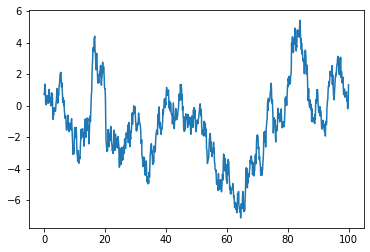

In [107]:
import matplotlib.pyplot as plt

X0=.75
theta=.10
mu=.75
sigma=.2
T=np.linspace(0,100,1000)
M=MRPRealization(X0,theta,mu,sigma,T)
plt.plot(M[:,0],M[:,1])


**Problem 2 - Maximum Likelihood Estimation**

Write a function called **MRPMLE** that takes as input the following

- M an $(N+1) \times 2$ matrix with 0th column containing the times $t_0,\ldots,t_N$ 
at which an MRP process is observed and whose 1th column contains the values of the process at those times
(like the output of the *MRPRealization* function)

- **maxtheta** - the maximum value of theta to use in a search for the theta parameter's MLE, so that the it is assumed that theta lies in the interval (0,maxtheta]

- **Ntheta**  - number of values of theta to search among, so the algorithm tries maxtheta*i/Ntheta, for i=1,...,Ntheta.

and outputs a 3-tuple containg the maximum likelihood estimators for the three parameters

- **theta**
- **mu**
- **sigma**

**in the order given here.**

In [169]:
def MRPMLE(M,maxtheta,Ntheta):
    N=M.shape[0]
    T=M[:,0]
    X=M[:,1]
    dT=np.diff(T)
    
    X0toNminus1=X[0:(N-1)]
    X1toN=X[1:N]
    
    for i in range(Ntheta):
        theta=(i+1)*maxtheta/Ntheta
        W=np.exp(-theta*dT)
        muhatnum=np.sum((X1toN-W*X0toNminus1)/(1+W))
        muhatden=np.sum((1-W)/(1+W))
        muhat=muhatnum/muhatden
        Mhat=W*X0toNminus1+muhat*(1-W)
        S=2*theta*np.sum(((X1toN-Mhat)**2)/(1-W**2))
        sigmahat=np.sqrt(S/(N-1))
        V=(sigmahat**2)*(1-W**2)/(2*theta)
        loglike=-.5*np.sum(V)-.5*np.sum(((X1toN-Mhat)**2)/V)
        if i==0:
            maxloglike=loglike
            thetaMLE=theta
            muMLE=muhat
            sigmaMLE=sigmahat
        else:
            if loglike>maxloglike:
                maxloglike=loglike
                thetaMLE=theta
                muMLE=muhat
                sigmaMLE=sigmahat
    return((thetaMLE,muMLE,sigmaMLE))
        
        
print(M.shape)
X0=.75
mu=1.25
sigma=.25
theta=2
T=np.linspace(0,100,1000)
M=MRPRealization(X0,theta,mu,sigma,T)
MRPMLE(M,5,1000)

(1000, 2)


(1.935, 1.2616092593323887, 0.21504282263341531)

**Problem 3 - Fitting MRP Model to Historical Spot Prices**

You have been provided with a file of historical RBOB Gasoline prices drawn from this website:

https://www.eia.gov/dnav/pet/hist/EER_EPMRR_PF4_Y05LA_DPGD.htm

Write a function **FitMRPtoRBOBData** that reads the file in from disk (without changes to the file before reading it in) and fit a MRP process using day as the unit of time. 

Your file should take as input:

- **fileid** = string with location where the datafile resides on disk as input
- **maxtheta** = the largest value of theta to try
- **Ntheta** the number of equispaced values of theta to try so that values tried are maxtheta*i/Ntheta, for i=1,...,Ntheta.

The function should read in the file, make the necessary changes to produce 1-d numpy arrays of times (in days) and prices, fit the MRP parameters, and output a 3-tuple consisting of the MLE's

- **thetahat**
- **muhat**
- **sigmahat**


in exactly this order. 


In [190]:
def FitMRPtoRBOBData(fileid,maxtheta,Ntheta):
    df=pd.read_csv(fileid,skiprows=2)
    df["Price"]=df.iloc[:,1]
    df.drop(columns=df.columns[1],inplace=True)
    df.drop(index=4797,inplace=True)
    df["Date"]=pd.to_datetime(df.Date)
    df["day"]=(df["Date"]-df["Date"].iloc[0])
    df["day"]=df["day"]/np.timedelta64(1,"D")
    T=df["day"].values
    X=df["Price"].values
    M=np.array([T,X]).T
    (theta,mu,sigma)=MRPMLE(M,.01,1000)
    return (theta,mu,sigma)
fileid="./RBOBGasolinePrices.csv"
maxtheta=1
Ntheta=1000
FitMRPtoRBOBData(fileid,maxtheta,Ntheta)

(0.00684, 2.1395600232077627, 0.06640782608593111)

**Problem 4**

Assign MLE estimators to the variables in the following cell.
The right hand sides should be *literals*. Try to get 3 significant digits of accuracy for the theta MLE. 

In [ ]:
thetahatRBOB=...
muhatRBOB=...
sigmahatRBOB=..

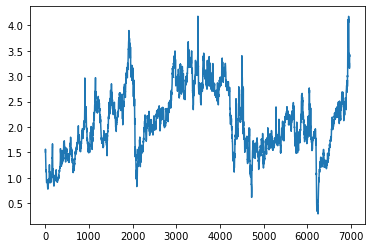

In [167]:
import matplotlib.pyplot as plt
plt.plot(M[:,0],M[:,1])


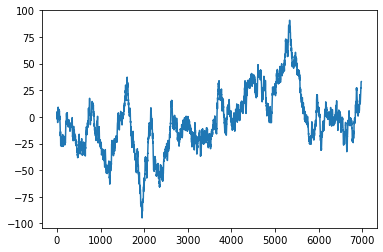

In [186]:
M=MRPRealization(X0,.001,mu,sigma,T)
plt.plot(M[:,0],M[:,1])

**Problem 5.**

Assuming that MRP model is valid for the RBOB data, use the parametric boostrap method to give 95% confidence intervals for the true parameters.
Make your confidence intervals based on bootstrap samples size of 1,000.

In the cell below, give the lower and upper confidence bounds for each parameter estimate. These should be **literals**.

In [ ]:
thetaRBOBlower=...
thetaRBOBupper=...
muRBOBlower=...
muRBOBupper=...
sigmaRBOBlower=...
sigmaRBOBupper=...
